In [1]:
from dataclasses import dataclass

import numpy as np
from scipy.optimize import root_scalar
%matplotlib widget
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams["figure.autolayout"] = True

In [2]:
from paths_image import PathsImage

@dataclass
class Path:
    name: str
    xyz: np.array
    lat: np.array
    lon: np.array
    sections = property(lambda self: self.lat.shape[0])

R_EQUAT = 2440.5  # Equatorial radius (semi-major)
R_POLAR = 2438.3  # Polar radius (semi-minor)
R_CIRC = (R_EQUAT + R_POLAR) / 2  # Radius to use for circular calcs

def get_all_paths() -> dict[str, Path]:
    paths: dict[str, Path] = {}
    for path_name, raw_points in PathsImage.PATHS.items():
        points = np.array(raw_points).T

        # Centre x-y and flip y b/c pixels go downwards
        points[0] -= PathsImage.CENTRE[0]
        points[1] = -(points[1] - PathsImage.CENTRE[1])
        # Scale from pixels to kilometres
        points = points * (R_CIRC / PathsImage.RADIUS)

        # Convert from x-y to latitude, longitude
        lat_rad = -np.arccos(np.hypot(points[0], points[1]) / R_CIRC)
        lon_rad = np.arctan2(points[1], points[0])
        lat, lon = np.rad2deg(lat_rad), np.rad2deg(lon_rad)

        # Save for later
        xyz = np.array([points[0], points[1], R_CIRC * np.sin(lat_rad)])
        path = Path(path_name, xyz, lat, lon)
        paths[path_name] = path
    return paths

PATHS = get_all_paths()

## Plot Path x-y Coordinates

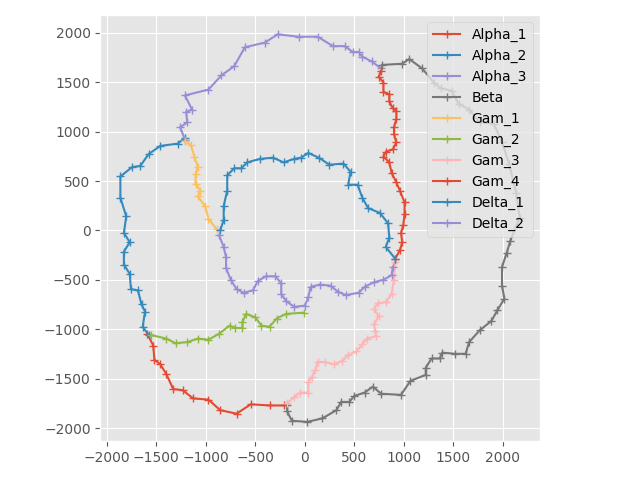

In [3]:
fig, ax = plt.subplots(1)
ax.set_aspect("equal")

for name, path in PATHS.items():
    ax.plot(path.xyz[0], path.xyz[1], "-+", label=name)
    # ax[0].plot(path.lat, "-+", label=name)
    # ax[1].plot(path.lon, "-+", label=name)

ax.legend()

## Plot 3D Plot of Paths

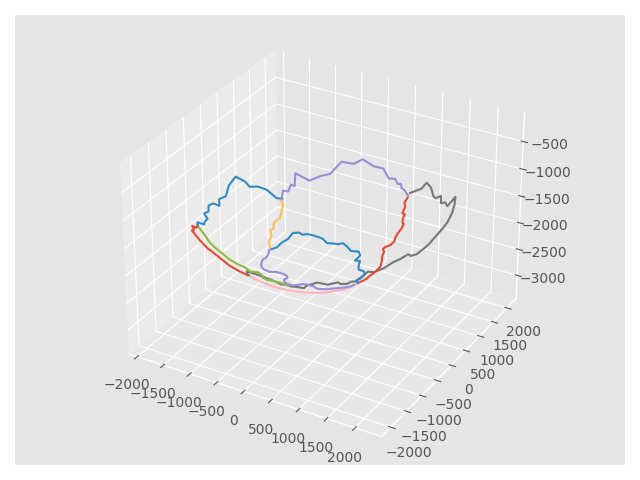

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for name, path in PATHS.items():
    ax.plot3D(path.xyz[0], path.xyz[1], path.xyz[2])

ax.set_aspect("equal")

## Total Path Distance

In [5]:
def haversine_distance(lat_1, lon_1, lat_2, lon_2):
    lat_1, lon_1 = np.deg2rad(lat_1), np.deg2rad(lon_1)
    lat_2, lon_2 = np.deg2rad(lat_2), np.deg2rad(lon_2)
    a = np.sin((lat_2 - lat_1) / 2) ** 2
    b = np.sin((lon_2 - lon_1) / 2) ** 2
    c = (a + b * np.cos(lat_1) * np.cos(lat_2))
    return R_CIRC * 2 * np.arctan2(np.sqrt(c), np.sqrt(1 - c))

def total_path_distance(path):
    tot_d = 0
    for i in range(1, path.sections):
        d = haversine_distance(path.lat[i - 1], path.lon[i - 1], path.lat[i], path.lon[i])
        tot_d += d
    return tot_d

print("Total Path Distances:")
for name, path in PATHS.items():
    tot_d = total_path_distance(path)
    print(f"  {name}: {tot_d:.2f} [km]")

Total Path Distances:
  Alpha_1: 2080.87 [km]
  Alpha_2: 2832.25 [km]
  Alpha_3: 3192.52 [km]
  Beta: 7156.76 [km]
  Gam_1: 1090.75 [km]
  Gam_2: 2031.66 [km]
  Gam_3: 2327.25 [km]
  Gam_4: 2295.36 [km]
  Delta_1: 3162.74 [km]
  Delta_2: 2787.36 [km]


## Terminator Speed

According to the RFP, the terminator moves at 3.63 km/h. A solar day on Mercury is 175.94 Earth days. The average longitudinal speed of the terminator is then approximately 0.08525 degrees per hour. We can calculate the time that the terminator will take to traverse a path using the min to max of longitudes achieved on a path.

In [6]:
TERM_LON_SPEED = (360 / 175.94)  # deg / day

print("Terminator Sweep Times:")
for name, path in PATHS.items():
    lon_range = np.ptp(np.unwrap(path.lon, period=360))
    term_time = (lon_range / TERM_LON_SPEED)  # days
    print(f"  {name}: {term_time} [Earth days]")

Terminator Sweep Times:
  Alpha_1: 24.347250880202207 [Earth days]
  Alpha_2: 34.966853200410355 [Earth days]
  Alpha_3: 38.20433912171569 [Earth days]
  Beta: 78.52058975607882 [Earth days]
  Gam_1: 17.69193545103469 [Earth days]
  Gam_2: 26.874725271417688 [Earth days]
  Gam_3: 37.388793243729616 [Earth days]
  Gam_4: 39.961149600024406 [Earth days]
  Delta_1: 96.43058615664017 [Earth days]
  Delta_2: 75.46198683618263 [Earth days]


## Required Traverse Speed

Required Path Traverse Speed (Mean, Max):
  Alpha_1: 1.021, 1.832 [m/s]
  Alpha_2: 0.997, 2.206 [m/s]
  Alpha_3: 1.081, 3.757 [m/s]
  Beta: 1.407, 11.257 [m/s]
  Gam_1: 1.381, 7.484 [m/s]
  Gam_2: 1.123, 2.750 [m/s]
  Gam_3: 2.519, 38.336 [m/s]
  Gam_4: 1.431, 15.736 [m/s]
  Delta_1: 0.395, 0.646 [m/s]
  Delta_2: 0.491, 1.228 [m/s]


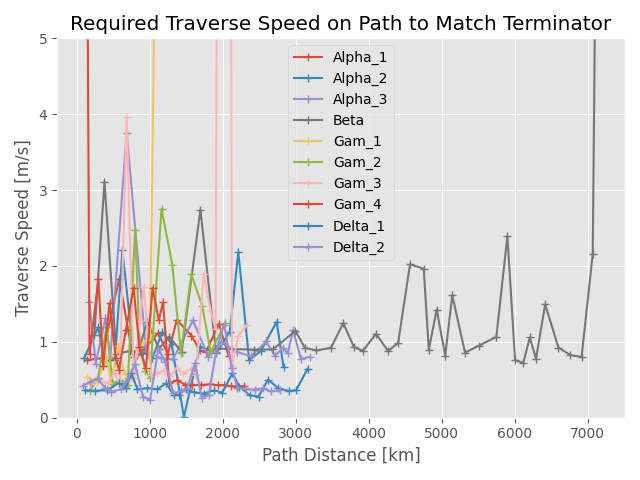

In [7]:
print("Required Path Traverse Speed (Mean, Max):")
fig, ax = plt.subplots()

SECS_PER_DAY = (24 * 60 * 60)

for name, path in PATHS.items():
    dists = []  # km
    req_speeds = []  # m / s

    for i in range(1, path.sections):
        delta_lon = np.abs(path.lon[i] - path.lon[i - 1])
        term_time = (delta_lon / TERM_LON_SPEED)

        path_dist = haversine_distance(path.lat[i - 1], path.lon[i - 1], path.lat[i], path.lon[i])
        req_speed = (path_dist / term_time)  # km / days
        req_speed_ms = (req_speed * 1000 / SECS_PER_DAY)

        dists.append(path_dist)
        req_speeds.append(req_speed_ms)

    req_speeds = np.array(req_speeds)
    print(f"  {name}: {np.mean(req_speeds):.3f}, {np.max(req_speeds):.3f} [m/s]")

    ax.plot(np.cumsum(dists), req_speeds, "-+", label=name)

ax.set_ylim(0, 5)
ax.set_xlabel("Path Distance [km]")
ax.set_ylabel("Traverse Speed [m/s]")
ax.set_title("Required Traverse Speed on Path to Match Terminator")
ax.legend()

## Basic Thermal Model

Text(0.5, 1.0, 'Surface Temp. Away from Subsolar Point')

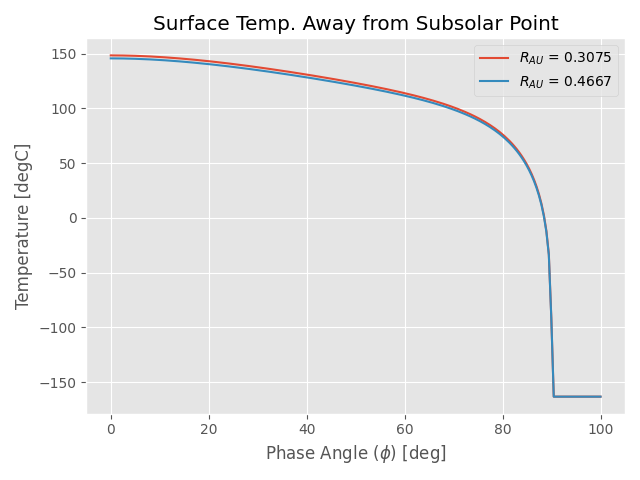

In [8]:
DEGC_TO_K = 273.15

def compute_surface_temp(phi, r):  # K
    T_COLD = 110  # K
    assert 0.3075 <= r <= 0.4667
    if phi > 90:
        return T_COLD
    T_subsolar = (407 + (8 / np.sqrt(r)))
    return (T_subsolar * (np.cos(np.deg2rad(phi)) ** (1/4))) + (T_COLD * (phi / 90) ** 3)

def phi_from_surface_temp(temp, r):
    sol = root_scalar(lambda phi: compute_surface_temp(phi, r) - temp, bracket=(0, 180))
    assert sol.converged
    return sol.root

fig, ax = plt.subplots()
phis = np.linspace(0, 100, 200)
for r_au in [0.3075, 0.4667]:
    surface_temps = [compute_surface_temp(phi, r_au) - DEGC_TO_K for phi in phis]
    ax.plot(phis, surface_temps, label=fr"$R_{{AU}}$ = {r_au}")
ax.legend()
ax.set_xlabel(r"Phase Angle ($\phi$) [deg]")
ax.set_ylabel("Temperature [degC]")
ax.set_title("Surface Temp. Away from Subsolar Point")

Phi for 20 degC: 87.49


Text(0.5, 1.0, 'Surface Temp. to Lagging/Advancing Longitude')

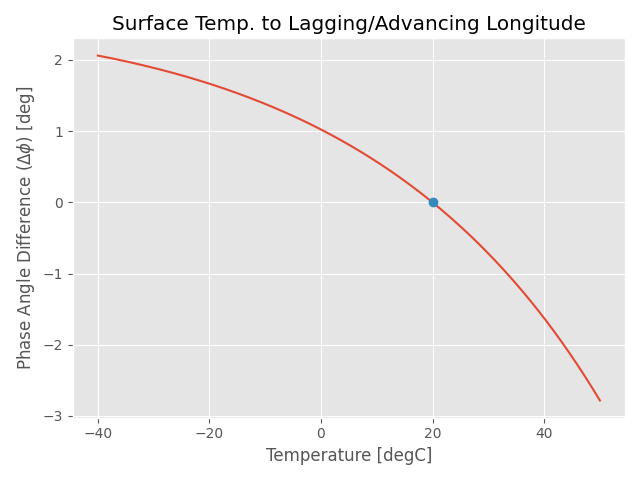

In [9]:
r_au = 0.38
temp_optimal = 20
temp_range = [-40, 50]
phi_optimal = phi_from_surface_temp(DEGC_TO_K + temp_optimal, r_au)
print(f"Phi for 20 degC: {phi_optimal:.2f}")
temps = np.linspace(*temp_range, 200)
phis = np.array([phi_from_surface_temp(DEGC_TO_K + temp, r_au) for temp in temps])
phis -= phi_optimal

fig, ax = plt.subplots()
ax.plot(temps, phis)
ax.plot(temp_optimal, 0, "o")
ax.set_xlabel("Temperature [degC]")
ax.set_ylabel(r"Phase Angle Difference ($\Delta\phi$) [deg]")
ax.set_title("Surface Temp. to Lagging/Advancing Longitude")

## Simulate Constant Speed Rover

Constant Speed Rover Temps. (Min, Mean, Max) [degC]:
Alpha_1: 7.52, 19.04, 20.00
Alpha_2: 9.76, 18.99, 20.00
Alpha_3: -44.63, 16.72, 20.00
Beta: -27.27, 16.56, 20.00
Gam_1: -1.82, 17.82, 20.00
Gam_2: -2.92, 16.92, 20.00
Gam_3: -45.03, 16.23, 20.00
Gam_4: -7.93, 18.39, 20.00
Delta_1: 20.00, 20.00, 20.00
Delta_2: 20.00, 20.00, 20.00


Text(0.5, 1.0, 'Temp. Along Constant Speed Rover @ 1.5 [m/s]')

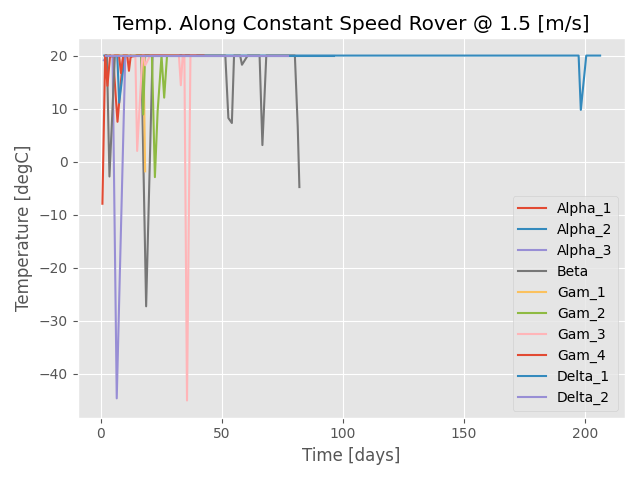

In [10]:
CONSTANT_ROVER_SPEED = 1.5  # m / s
R_AU = 0.38
TEMP_OPTIMAL = 20  # degC
PHI_OPTIMAL = phi_from_surface_temp(DEGC_TO_K + TEMP_OPTIMAL, R_AU)

print("Constant Speed Rover Temps. (Min, Mean, Max) [degC]:")
fig, ax = plt.subplots()

for name, path in PATHS.items():
    temps = []
    times = []
    for i in range(1, path.sections):
        path_dist = haversine_distance(path.lat[i - 1], path.lon[i - 1], path.lat[i], path.lon[i])

        rover_time = (path_dist / (1e-3 * SECS_PER_DAY * CONSTANT_ROVER_SPEED))  # days
        term_lon_change = (TERM_LON_SPEED * rover_time)  # deg

        delta_lon = np.abs(path.lon[i] - path.lon[i - 1])
        ahead_of_term = (delta_lon - term_lon_change)

        # Wait for terminator to catch up if ahead
        time = rover_time + (max(0, ahead_of_term) / TERM_LON_SPEED)
        times.append(time)

        # We don't allow going ahead of the terminator (for now)
        delta_phi = min(ahead_of_term, 0)
        # Plus if driving towards cold, mimus for hot
        temp = compute_surface_temp(PHI_OPTIMAL - delta_phi, R_AU)
        temps.append(temp)

    times, temps = np.cumsum(times), np.array(temps, dtype=np.float64)
    temps -= DEGC_TO_K

    print(f"{name}: {np.min(temps):.2f}, {np.mean(temps):.2f}, {np.max(temps):.2f}")
    ax.plot(times, temps, label=name)

ax.legend()
ax.set_xlabel("Time [days]")
ax.set_ylabel("Temperature [degC]")
ax.set_title(f"Temp. Along Constant Speed Rover @ {CONSTANT_ROVER_SPEED} [m/s]")